# Project Description (data and tasks)
We are working with data from the TMDB box office, which describes a number of categorical features (eg. release_year, spoken_languages) and numeric features (eg. budget, runtime, homepage). Additionally we will be adding new hash features into our pipeline (eg.production companies, languages). We will use these features to predict the revenue of each movie in the test set. The challenge here is to predict the worldwide revenue for 4,398 (100 in practice) movies in the test file given various information about the movie. The tasks to be completed in phase 3 require adding the hash features of production countries, spoken languages, keywords, along with the cast and crew. We also plan to intergrate a decision tree regression model (xgboost) to help improve our score and accuracy.

# 1 Import and Init 

## 1.1 Python and Stuffs

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split  # sklearn.cross_validation in old versions
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from time import time
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import random
import pandas as pd
import os

In [5]:
seed=45
random.seed(seed)
np.random.seed(seed)

## 1.2 Parameters 


In [1]:
# Filesystem
Data_dir = "/home/onyxia/work/TMDb-Box-Office-Predicti/home/onyxia/work/TMDb-Box-Office-Prediction/Data/"   #same level as course repo in the data directory
Codes_dir = "/home/onyxia/work/TMDb-Box-Office-Predicti/home/onyxia/work/TMDb-Box-Office-Prediction/Codes" 
Outputs_dir="/home/onyxia/work/TMDb-Box-Office-Prediction/Outputs/" 
csv_filename="TMDB_movie_dataset_v11"
      ##afficher le contenu du repertoire DATA_DIR
!ls -l $Data_dir
# Preprocessing andd load
scale=0.2

# Modele

ls: cannot access '/home/onyxia/work/TMDb-Box-Office-Predicti/home/onyxia/work/TMDb-Box-Office-Prediction/Data/': No such file or directory


# 2 Load Data


## 2.1 Retrive Data

In [6]:

def load_data(in_path, name,n_display=1,show_info=False,sep=",",nrows=720000):
    df = pd.read_csv(in_path,sep=",",nrows=nrows)
    #df.set_index('id', inplace=True)
    print(f"{name}: shape is {df.shape}")
    if show_info==True:
        print(df.info())
    
    display(df.head(n_display))
    return df


In [8]:
Data_dir="/home/onyxia/work/TMDb-Box-Office-Prediction/Data/"
ds_name="Raw_Data"
Raw_df = load_data(os.path.join(Data_dir, f'{csv_filename}.csv'), ds_name)



Raw_Data: shape is (720000, 24)


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."


In [9]:
Raw_df = Raw_df.rename(columns={'keywords': 'Keywords'})


In [10]:
Raw_df.Keywords[0]
#"[{'name': 'Original Film', 'id': 333}, {'name': 'Monarch Pictures', 'id': 966}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]"

'rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious'

In [11]:
columns=Raw_df.columns
columns


Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'Keywords'],
      dtype='object')

In [12]:
cols_to_drop=["title","vote_average","vote_count","runtime","adult","backdrop_path","original_title","overview","tagline","original_title"]

In [13]:
def get_col_to_keep(all_columns=columns,cols_to_drop=cols_to_drop):
    
    return list(set(all_columns).difference(set(cols_to_drop)))

In [14]:
cols_to_keep=get_col_to_keep()
cols_to_keep

['popularity',
 'imdb_id',
 'genres',
 'production_companies',
 'original_language',
 'revenue',
 'Keywords',
 'id',
 'homepage',
 'release_date',
 'budget',
 'status',
 'poster_path',
 'spoken_languages',
 'production_countries']

In [16]:
work_df=Raw_df[cols_to_keep].copy()

In [17]:
ds_name = 'Work_df'
print(f'dataset {ds_name:24}: [ {work_df.shape[0]:10,}, {work_df.shape[1]}]')

dataset Work_df                 : [    720,000, 15]


# 3 Descriptive Statistique


In [19]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720000 entries, 0 to 719999
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   popularity            720000 non-null  float64
 1   imdb_id               425659 non-null  object 
 2   genres                476525 non-null  object 
 3   production_companies  371007 non-null  object 
 4   original_language     720000 non-null  object 
 5   revenue               720000 non-null  int64  
 6   Keywords              233628 non-null  object 
 7   id                    720000 non-null  int64  
 8   homepage              82893 non-null   object 
 9   release_date          627085 non-null  object 
 10  budget                720000 non-null  int64  
 11  status                720000 non-null  object 
 12  poster_path           535867 non-null  object 
 13  spoken_languages      461512 non-null  object 
 14  production_countries  442271 non-null  object 
dtype

In [20]:
work_df.describe() #only  numerical features

,popularity,revenue,id,budget
count,720000.000000,7.200000e+05,7.200000e+05,7.200000e+05
mean,1.585407,1.035537e+06,7.158026e+05,3.985571e+05
std,9.496412,2.155208e+07,3.975829e+05,5.916915e+06
min,0.000000,-1.200000e+01,2.000000e+00,0.000000e+00
25%,0.600000,0.000000e+00,3.850095e+05,0.000000e+00
50%,0.600000,0.000000e+00,8.305680e+05,0.000000e+00
75%,1.149000,0.000000e+00,1.076050e+06,0.000000e+00
max,2994.357000,3.000000e+09,1.271173e+06,9.000000e+08


In [21]:
# convertir les revenu negatifs
work_df.revenue=work_df.revenue.apply(abs)

In [22]:
work_df.describe() #only 3 numerical features

,popularity,revenue,id,budget
count,720000.000000,7.200000e+05,7.200000e+05,7.200000e+05
mean,1.585407,1.035537e+06,7.158026e+05,3.985571e+05
std,9.496412,2.155208e+07,3.975829e+05,5.916915e+06
min,0.000000,0.000000e+00,2.000000e+00,0.000000e+00
25%,0.600000,0.000000e+00,3.850095e+05,0.000000e+00
50%,0.600000,0.000000e+00,8.305680e+05,0.000000e+00
75%,1.149000,0.000000e+00,1.076050e+06,0.000000e+00
max,2994.357000,3.000000e+09,1.271173e+06,9.000000e+08


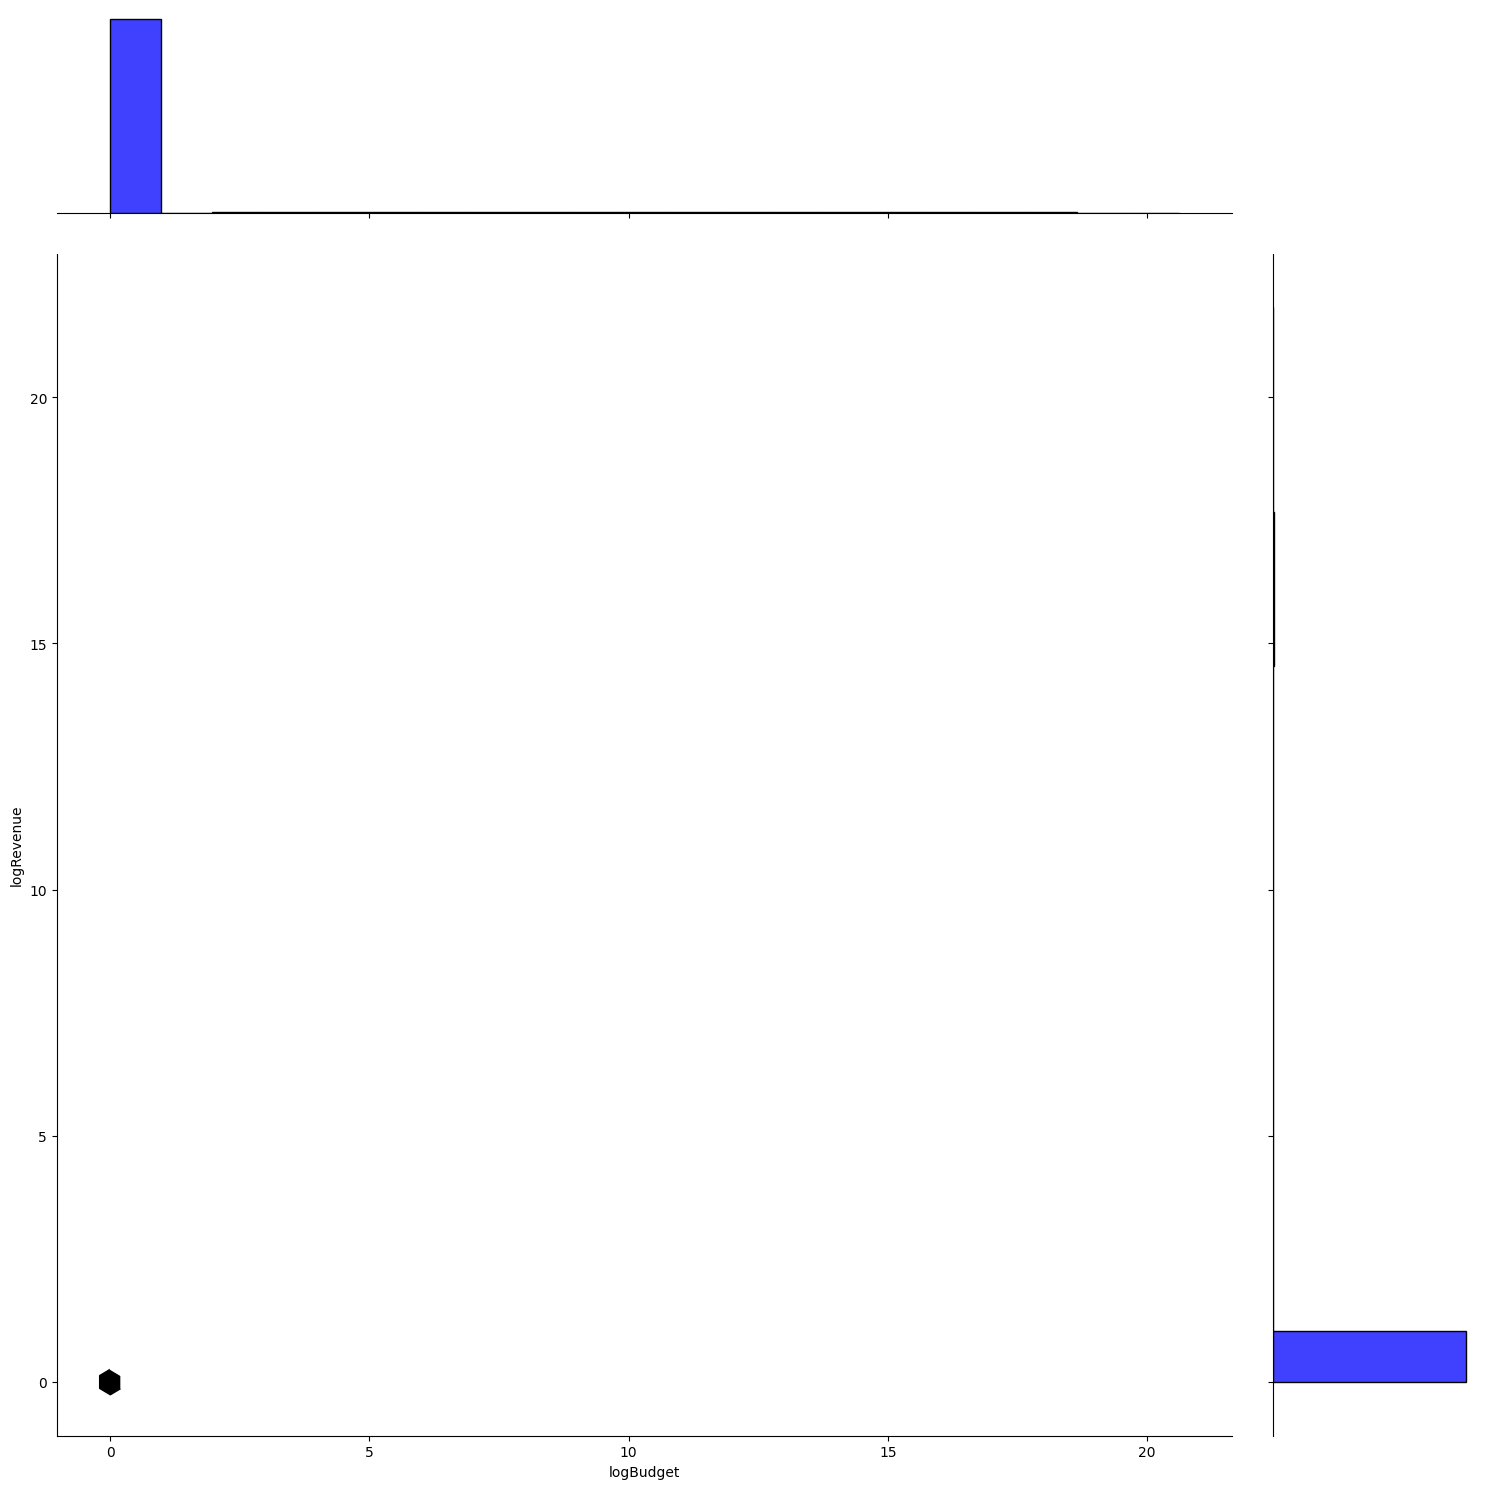

In [23]:
work_df['logRevenue']=np.log1p(work_df['revenue'])
work_df['logBudget']=np.log1p(work_df['budget'])
sns.jointplot(x="logBudget", y="logRevenue", data=work_df, height=15, ratio=5, color="b", kind='hex')


In [25]:
#convertir les revevue et les budgets

def convertator(df=work_df,size=100000,columns=['revenue','budget']):
    n=len(columns)
    for i in range(n):
        
        df[columns[i]]=df[columns[i]]/size
    return df 


In [26]:
df_work=convertator().copy()

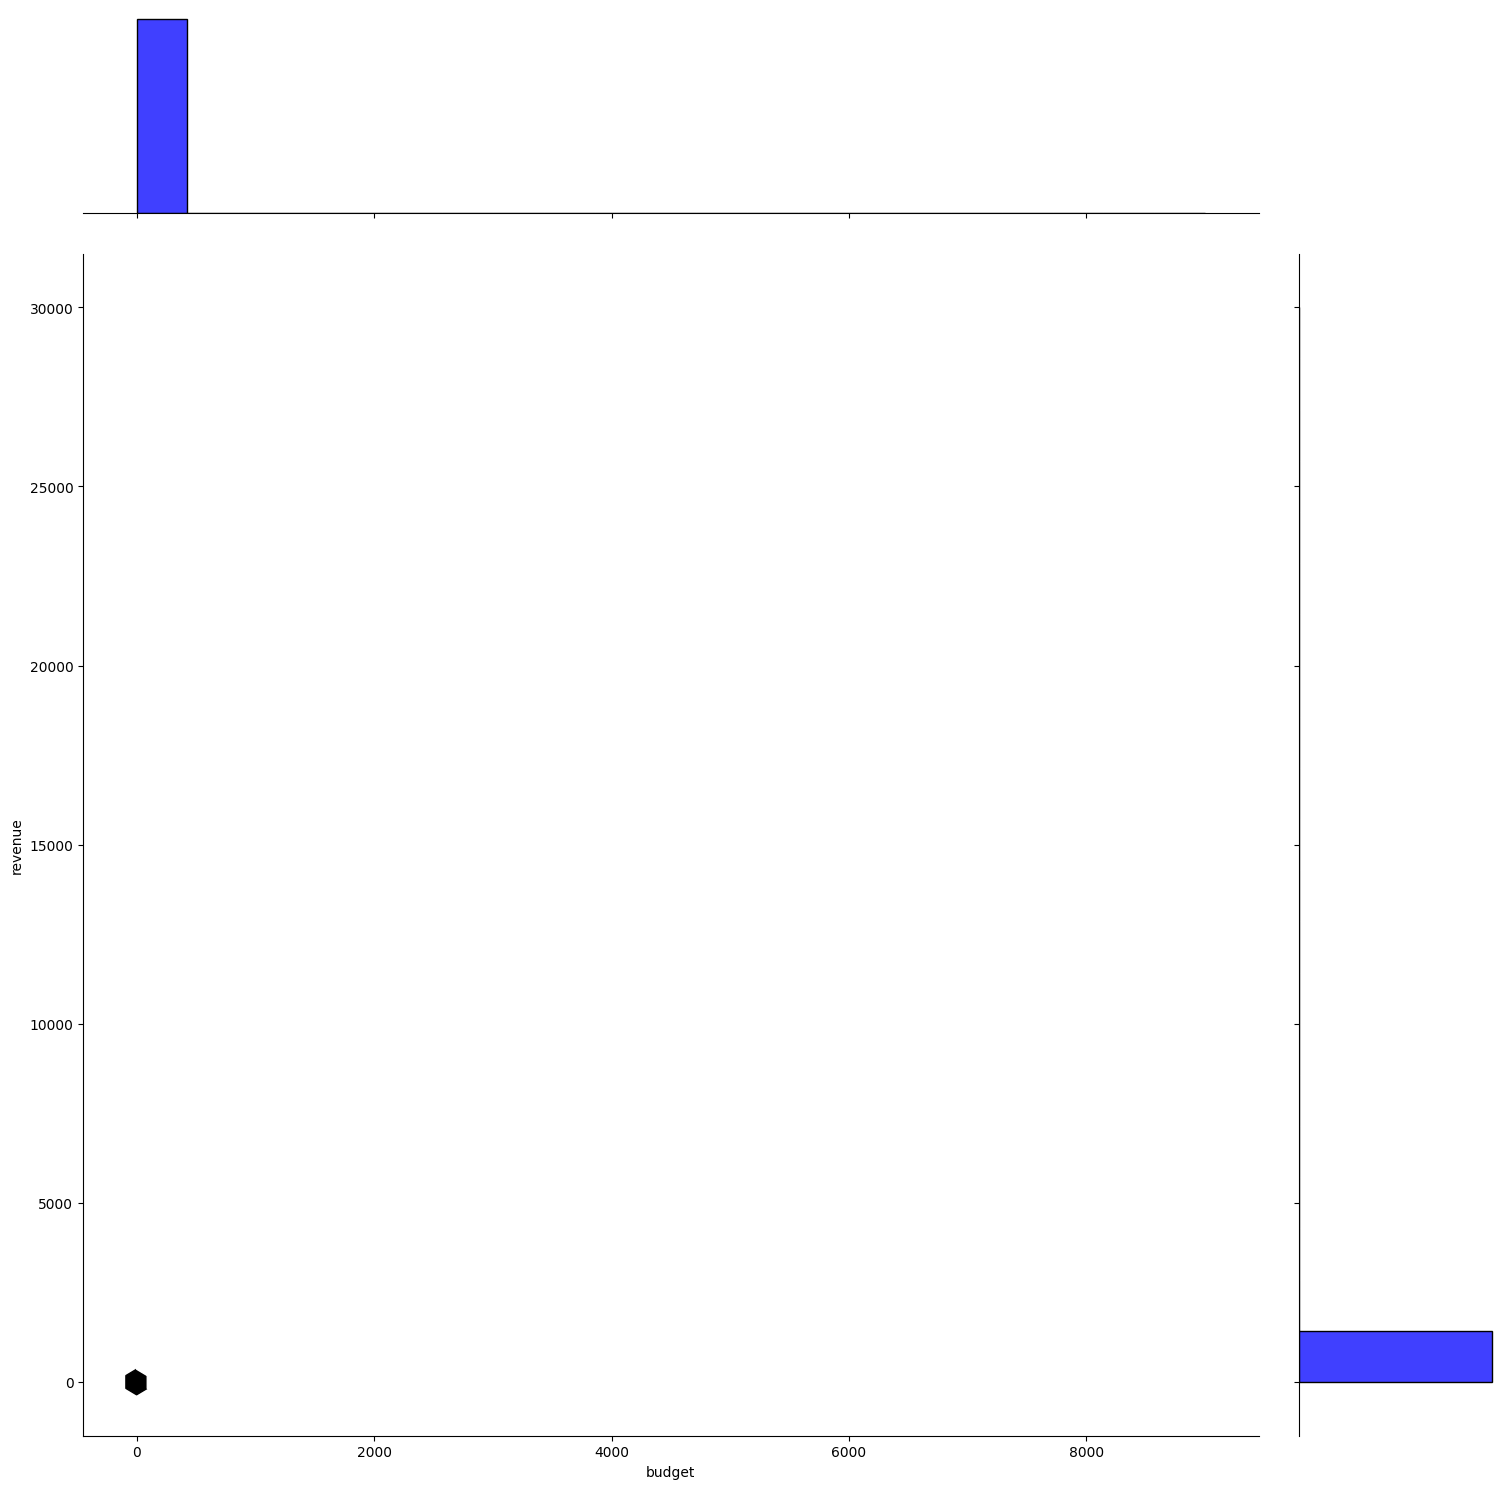

In [27]:
#df_work['logRevenue']=np.log1p(df_work['revenue'])
#df_work['logBudget']=np.log1p(df_work['budget'])
sns.jointplot(x="budget", y="revenue", data=df_work, height=15, ratio=5, color="b", kind='hex')


### Distribution of the target column 

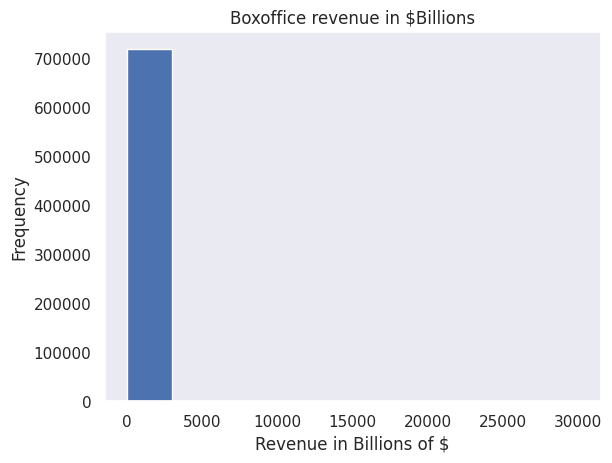

In [28]:
# necessary imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
df_work['revenue'].astype(float).plot.hist(bins=10)
plt.xlabel("Revenue in Billions of $")
plt.ylabel("Frequency")
plt.title("Boxoffice revenue in $Billions")
plt.grid()


In [29]:
df_work.revenue[df_work.revenue>0].shape

(18796,)

In [30]:
df_work.revenue[df_work.budget>0].shape

(42631,)

In [31]:
# Ne garder que les films dont les revenu sont disponilble
final_work_df=df_work[(df_work.budget>0) & (df_work.revenue>0)].copy()

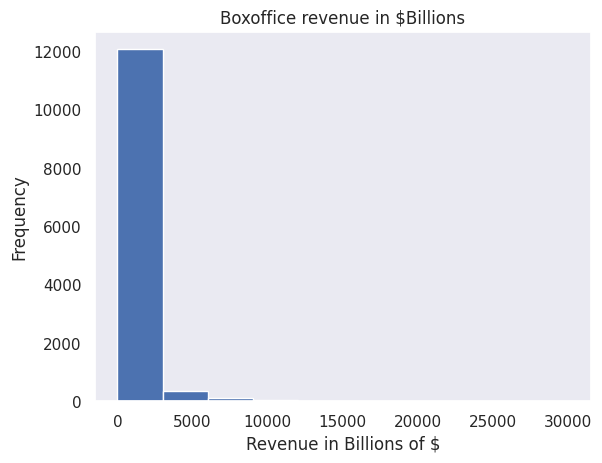

In [32]:
# necessary imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
final_work_df['revenue'].astype(float).plot.hist(bins=10)
plt.xlabel("Revenue in Billions of $")
plt.ylabel("Frequency")
plt.title("Boxoffice revenue in $Billions")
plt.grid()


In [33]:
def fillnan(column_,df=final_work_df,mode_="median"):
      df[column_].fillna(mode_,inplace=True)
      print("well done")

In [34]:
#final_work_df['popularity'].final_work_df('median')
fillnan("budget")
fillnan("popularity")



well done
well done


/tmp/ipykernel_210388/3375539410.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_].fillna(mode_,inplace=True)


/tmp/ipykernel_210388/111727333.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_work_df['revenue'] )


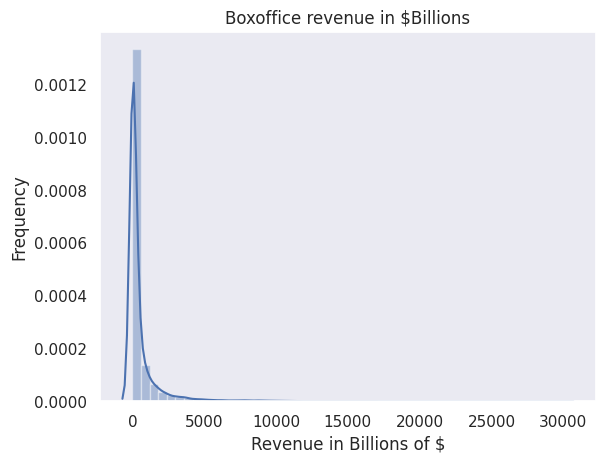

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
sns.distplot(final_work_df['revenue'] )
plt.xlabel("Revenue in Billions of $")
plt.ylabel("Frequency")
plt.title("Boxoffice revenue in $Billions")
plt.grid()


#### Take log of target variable (revenue)
Because revenue variable is skewed, let's calculate log of it.



/tmp/ipykernel_210388/610950083.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_work_df['logRevenue'] )


Text(0.5, 1.0, 'log Boxoffice revenue in $Billions')

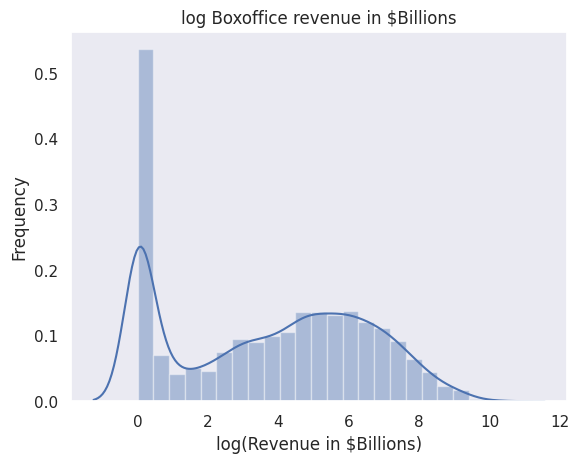

In [36]:
final_work_df['logRevenue'] = np.log1p(final_work_df['revenue'])
sns.distplot(final_work_df['logRevenue'] )
plt.grid()
plt.xlabel("log(Revenue in $Billions)")
plt.ylabel("Frequency")
plt.title("log Boxoffice revenue in $Billions")


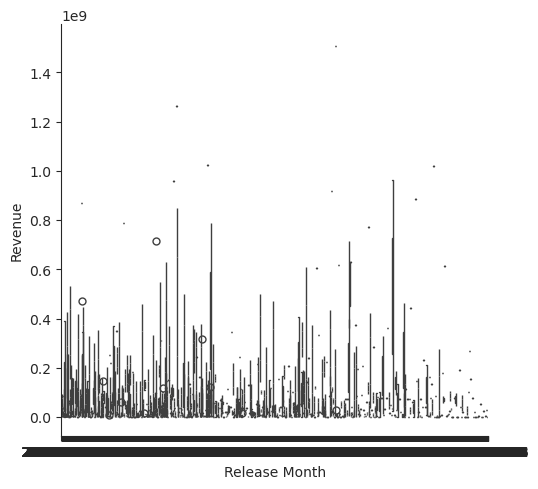

In [132]:
#Run cells below before running completely the preprocessing
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="release_date",y= "revenue", data=df_train, kind="box")
    g.set_axis_labels("Release Month", "Revenue");
    

In [40]:
colonnes_objects = df_train.select_dtypes(include=['object']).columns.tolist()


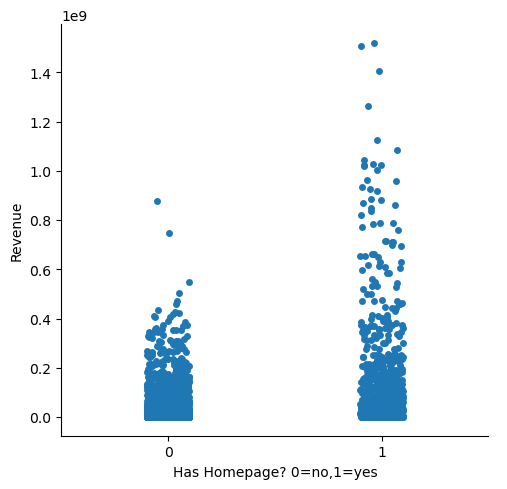

In [130]:
#Run cells below before running completely the preprocessing
g=sns.catplot(x="has_homepage", y="revenue", data=df_train);
g.set_axis_labels("Has Homepage? 0=no,1=yes", "Revenue");

<Axes: >

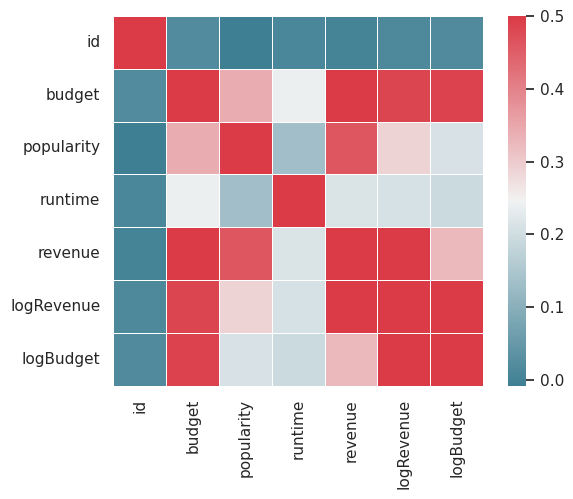

In [32]:
colonnes_numeriques = df_train.select_dtypes(include=['int', 'float']).columns.tolist()
num_df_train=df_train[colonnes_numeriques]
corr=num_df_train.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.5, square=True, linewidths=.5)

#  4 Preprocessing


##  4.1 Fill NaN Update and/or Convert in power 6 some column values 
for instance updating the budget of Beethoven movie 

## 4.2 Clean categorical features


In [37]:

categorical = [ 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords']


## 4.3 Encoding
Genre,Belongs_to_Collection and Homepage Binarization

## 4.3.2 One Encoding

In [38]:
final_work_df.genres[1]

'Adventure, Drama, Science Fiction'

### 4.3.2.1 Slight transfomation on "genres" variable

In [39]:

def gender_preprocessing(df):
    # set a liste containing all movie genders 
    X_all_genres = df['genres'].str.split(', ', expand=True)
    # Convertir chaque genre en colonnes binaires
    X_all_genres = pd.get_dummies(X_all_genres.apply(lambda x: pd.Series(x).str.strip()), prefix='', prefix_sep='').groupby(level=0, axis=1).sum()
    
    # Renommer les colonnes binaires pour correspondre aux noms de colonnes du premier code
    X_all_genres.columns = ['genre_' + col.replace(' ', '_') for col in X_all_genres.columns]
    # Ajouter les colonnes binaires encodées en one-hot au DataFrame complet
    X_all = pd.concat([df, X_all_genres], axis=1)

    return X_all


In [40]:
final_DF_work=gender_preprocessing(final_work_df)

/tmp/ipykernel_210388/1908571225.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_all_genres = pd.get_dummies(X_all_genres.apply(lambda x: pd.Series(x).str.strip()), prefix='', prefix_sep='').groupby(level=0, axis=1).sum()


In [112]:
final_DF_work.head(2)

,genres,original_language,Keywords,spoken_languages,homepage,popularity,production_countries,production_companies,release_date,poster_path,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western
0,"Action, Science Fiction, Adventure",en,"rescue, mission, dream, airplane, paris, franc...","English, French, Japanese, Swahili",https://www.warnerbros.com/movies/inception,83.952,"United Kingdom, United States of America","Legendary Pictures, Syncopy, Warner Bros. Pict...",2010-07-15,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,...,0,0,0,0,0,1,0,0,0,0
1,"Adventure, Drama, Science Fiction",en,"rescue, future, spacecraft, race against time,...",English,http://www.interstellarmovie.net/,140.241,"United Kingdom, United States of America","Legendary Pictures, Syncopy, Lynda Obst Produc...",2014-11-05,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,...,0,0,0,0,0,1,0,0,0,0


In [41]:
def shuffle_split(df=final_DF_work,scale=0.25,target = "revenue"):   

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_remind, y_train, y_remind = train_test_split(X, y, train_size=(1-scale), random_state=42)
    X_val, X_test,  y_val, y_test = train_test_split(X_remind, y_remind, test_size=0.8, random_state=42)
    # 0.8 = 80% des donnes restant por le jeu de test et les 20% pour la validation

    print("(x.shape, y.shape )","\n")
    print ( " Pour le train :", X_train.shape, y_train.shape,"\n" )
    print ( " Pour le test :" ,X_test.shape, y_test.shape,"\n" )
    print ( " Pour la validation :", X_val.shape, y_val.shape,"\n" )

    return (X_train, y_train), ( X_test, y_test),( X_val, y_val)


In [42]:
    (X_train, y_train), ( X_test, y_test),( X_valid, y_valid)=shuffle_split()

(x.shape, y.shape ) 

 Pour le train : (9465, 35) (9465,) 

 Pour le test : (2525, 35) (2525,) 

 Pour la validation : (631, 35) (631,) 



In [43]:
X_train.columns

Index(['popularity', 'imdb_id', 'genres', 'production_companies',
       'original_language', 'Keywords', 'id', 'homepage', 'release_date',
       'budget', 'status', 'poster_path', 'spoken_languages',
       'production_countries', 'logRevenue', 'logBudget', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery',
       'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie',
       'genre_Thriller', 'genre_War', 'genre_Western'],
      dtype='object')

In [44]:
# Binarization of "homepagee, "released"

X_train['has_homepage'] = 1
X_train.loc[pd.isnull(X_train['homepage']) ,"has_homepage"] = 0
X_test['has_homepage'] = 1
X_test.loc[pd.isnull(X_test['homepage']) ,"has_homepage"] = 0
X_valid['has_homepage'] = 1
X_valid.loc[pd.isnull(X_valid['homepage']) ,"has_homepage"] = 0


X_train['released'] = 1
X_train.loc[pd.isnull(X_train['status']) ,"released"] = 0
X_test['released'] = 1
X_test.loc[pd.isnull(X_test['status']) ,"released"] = 0
X_valid['released'] = 1
X_valid.loc[pd.isnull(X_valid['status']) ,"released"] = 0


Let's get a count of how many production countries are involved in a production

In [45]:
X_train.production_countries.iloc[45]

'United States of America'

In [46]:

# Définir la fonction count_strings
def count_strings(s):
    """
    Cette fonction compte le nombre de sous-chaînes séparées par des virgules dans une chaîne donnée.
    
    Args:
    - s (str): La chaîne de caractères à analyser.
    
    Returns:
    - int: Le nombre de sous-chaînes, ou NaN si la chaîne est nulle.
    """
    # Vérifier si la chaîne est nulle
    if pd.isna(s):
        return np.nan
    
    # Diviser la chaîne en fonction des virgules et compter le nombre de sous-chaînes obtenues
    return len(s.split(','))



In [47]:
# Appliquer la fonction count_strings à la colonne 'genres' du DataFrame
X_train['production_countries_count'] = X_train['production_countries'].apply(count_strings)
X_test['production_countries_count'] = X_test['production_countries'].apply(count_strings)
X_valid['production_countries_count'] = X_valid['production_countries'].apply(count_strings)


In [48]:
X_train.columns

Index(['popularity', 'imdb_id', 'genres', 'production_companies',
       'original_language', 'Keywords', 'id', 'homepage', 'release_date',
       'budget', 'status', 'poster_path', 'spoken_languages',
       'production_countries', 'logRevenue', 'logBudget', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery',
       'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie',
       'genre_Thriller', 'genre_War', 'genre_Western', 'has_homepage',
       'released', 'production_countries_count'],
      dtype='object')

### Production Companies

In [49]:
X_train.production_countries.iloc[:2]

2640              France, United Kingdom
3013    Canada, United States of America
Name: production_countries, dtype: object

In [50]:
# Appliquer la fonction count_strings aux  colonnes 'production_companies_count' et"spoken_languages_count" du DataFrame

# take counts of each
X_train['production_companies_count'] = X_train['production_companies'].apply(count_strings)
X_train['spoken_languages_count'] = X_train['spoken_languages'].apply(count_strings)

X_test['production_companies_count'] = X_test['production_companies'].apply(count_strings)
X_test['spoken_languages_count'] = X_test['spoken_languages'].apply(count_strings)

X_valid['production_companies_count'] = X_valid['production_companies'].apply(count_strings)
X_valid['spoken_languages_count'] = X_valid['spoken_languages'].apply(count_strings)

In [51]:
X_train.production_companies_count.shape

(9465,)

## Keywords, cast, crew

In [52]:
# number of keywords
X_train['keyword_count'] = X_train['Keywords'].apply(count_strings)
X_test['keyword_count'] = X_test['Keywords'].apply(count_strings)
X_valid['keyword_count'] = X_valid['Keywords'].apply(count_strings)

In [127]:
X_train.columns

Index(['genres', 'original_language', 'Keywords', 'spoken_languages',
       'homepage', 'popularity', 'production_countries',
       'production_companies', 'release_date', 'poster_path', 'id', 'status',
       'budget', 'imdb_id', 'logRevenue', 'logBudget', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery',
       'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie',
       'genre_Thriller', 'genre_War', 'genre_Western', 'has_homepage',
       'released', 'production_countries_count', 'production_companies_count',
       'spoken_languages_count', 'keyword_count'],
      dtype='object')

## Fixing Release Date
    "la date de sortie prévue ou de la date de publication d'un produit ou d'un service."

In [53]:
X_train.release_date.isnull().sum()*100/X_train.shape[0],X_test.release_date.isnull().sum()*100/X_test.shape[0],X_valid.release_date.isnull().sum()*100/X_valid.shape[0]



(8.811410459587956, 8.752475247524753, 8.55784469096672)

In [54]:
#autour de 9% , je décide alors de les (les valeurs nulles de la colonne release) supprimer
train_x,train_y=X_train[X_train.release_date.isnull()==False],y_train[X_train.release_date.isnull()==False]
test_x,test_y=X_test[X_test.release_date.isnull()==False],y_test[X_test.release_date.isnull()==False]
val_x,val_y=X_valid[X_valid.release_date.isnull()==False],y_valid[X_valid.release_date.isnull()==False]

In [55]:
train_x.release_date.isnull().sum(),test_x.release_date.isnull().sum(),val_x.release_date.isnull().sum()


(0, 0, 0)

In [56]:
xtn,ytn=train_x.copy(),train_y.copy()  # xtn = x train
xts,yts=test_x.copy(),test_y.copy()     
xv,yv=val_x.copy(),val_y.copy()

In [57]:
train_index=xtn.release_date.index
test_index=xts.release_date.index
validation_index=xv.release_date.index

In [58]:
xtn.release_date[train_index[0]],xtn.release_date[train_index[0]][5:7]


('2011-12-26', '12')

In [59]:
#import re # extraire l'année à 4 chiffres à partir d'une chaîne représentant une date
def datefix(x): # run year fix, then date fix
    
    r = x[:4]
    return int(r)


In [60]:
x=xtn.release_date[train_index[0]]
x,datefix(x)

('2011-12-26', 2011)

In [61]:
# Train
xtn['release_year'] = xtn['release_date'].apply(lambda x: datefix(x))


# Test
xts['release_year'] = xts['release_date'].apply(lambda x: datefix(x))

# Validation

xv['release_year'] = xv['release_date'].apply(lambda x: datefix(x))

In [62]:
#import re # extraire l'année à 4 chiffres à partir d'une chaîne représentant une date
def datefix_month(x): # run year fix, then date fix
    
    r = x[5:7]
    return int(r)


In [63]:
 # set to datetime ,then  month of release date 

 ## Train
xtn['release_month']=xtn["release_date"].apply(lambda x: datefix_month(x))

## Test

xts['release_month']=xts["release_date"].apply(lambda x: datefix_month(x)) 

## Validation

xv['release_month']=xv["release_date"].apply(lambda x: datefix_month(x))


In [64]:
xtn.columns

Index(['popularity', 'imdb_id', 'genres', 'production_companies',
       'original_language', 'Keywords', 'id', 'homepage', 'release_date',
       'budget', 'status', 'poster_path', 'spoken_languages',
       'production_countries', 'logRevenue', 'logBudget', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery',
       'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie',
       'genre_Thriller', 'genre_War', 'genre_Western', 'has_homepage',
       'released', 'production_countries_count', 'production_companies_count',
       'spoken_languages_count', 'keyword_count', 'release_year',
       'release_month'],
      dtype='object')

In [65]:
xtn.shape,ytn.shape[0]

((8631, 43), 8631)

In [66]:
part1=['Keywords', 'spoken_languages',
       'homepage', 'production_countries',
       'production_companies', 'release_date', 'poster_path', 'id', 'status']
part2=['imdb_id', 'logRevenue', 'logBudget',"released"]
col_to_drop=set(part1+part2)
final_col_to_keep=list(set(xtn.columns).difference(col_to_drop))

In [67]:
## apply Log function to features durint the preprocessing
class Log1pTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)

# Pipeline

<img src="images/Pipeline2.png">


In [68]:
# Séquence à rechercher
sequence = 'genre_'

# Filtrer les éléments de la liste qui commencent par la séquence
genre_column_names = [element for element in final_col_to_keep if element.startswith(sequence)]

In [69]:
set(final_col_to_keep).difference(set(genre_column_names))

{'budget',
 'genres',
 'has_homepage',
 'keyword_count',
 'original_language',
 'popularity',
 'production_companies_count',
 'production_countries_count',
 'release_month',
 'release_year',
 'spoken_languages_count'}

In [70]:
from sklearn.feature_extraction.text import HashingVectorizer

log_num_feats = ["budget", "popularity"]
#num_feats = ["Duration"] # non requis, à explorer ultérieurement
#date_feats = ['release_date' , "release_month"]
#cat_feats = ['belongs_to_collection', 'has_homepage', 'released']
cat_feats = [ 'has_homepage','release_month','release_year']

encode_feats = genre_column_names

hash_feats = ['production_countries_count', 'production_companies_count', 'spoken_languages_count','keyword_count']

#hash_feats = ['production_countries_count', 'production_companies_count', 'spoken_languages_count',
             #'keyword_count', 'cast_count', 'crew_count']

log_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('logger', Log1pTransformer()),
    ('scaler', StandardScaler()) # peut-être supprimé plus tard - juste un test
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

date_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    #  ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

hash_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

data_pipeline = ColumnTransformer([
    # nom, pipeline, caractéristiques
    ('log_num_feats', log_pipe, log_num_feats),
    
    ('cat_feats', cat_pipeline, cat_feats),
    ('encode_feats', encode_pipeline, encode_feats),
    ('hash_feats', hash_pipe, hash_feats)
], remainder='drop', # passthrough ou drop?
n_jobs=-1)

#('numerical_feats', num_pipeline, num_feats),

In [72]:
col=log_num_feats+cat_feats+encode_feats+hash_feats #+num_feats

In [73]:
xtn[col].isna().sum()

budget                           0
popularity                       0
has_homepage                     0
release_month                    0
release_year                     0
genre_Thriller                   0
genre_TV_Movie                   0
genre_Comedy                     0
genre_Adventure                  0
genre_War                        0
genre_Music                      0
genre_Horror                     0
genre_History                    0
genre_Action                     0
genre_Drama                      0
genre_Family                     0
genre_Science_Fiction            0
genre_Fantasy                    0
genre_Romance                    0
genre_Western                    0
genre_Crime                      0
genre_Animation                  0
genre_Documentary                0
genre_Mystery                    0
production_countries_count     565
production_companies_count     643
spoken_languages_count         454
keyword_count                 1295
dtype: int64

In [74]:
xtn = xtn[col].fillna(xtn[col].median())
xts = xts[col].fillna(xts[col].median())
xv = xv[col].fillna(xv[col].median())


In [142]:
#X_train["release_date"] = pd.to_datetime(X_train["release_date"], format='%m/%d/%y')

In [75]:
xtn1=xtn[col].copy()
xv1=xv[col].copy()
xts1=xts[col].copy()

In [76]:
df_train_processed = data_pipeline.fit_transform(xtn)
df_test_processed = data_pipeline.fit_transform(xts1)
df_val_processed = data_pipeline.fit_transform(xv1)

In [77]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

def normalize_y(y_train):
    # Créer un objet StandardScaler
    scaler = StandardScaler()

    # Adapter et transformer les données de y_train
    y_train_normalized = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

    # Récupérer la moyenne et l'écart type
    mean_normalized = scaler.mean_
    std_dev_normalized = scaler.scale_

    return y_train_normalized, mean_normalized, std_dev_normalized

In [78]:
y_train_processed,y_train_mean,y_train_std = normalize_y(np.log1p(ytn))
y_test_processed,y_test_mean,y_test_std  = normalize_y(np.log1p(yts))
y_val_processed,y_val_mean,y_val_std  = normalize_y(np.log1p(yv))

# Modeling

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
models = {'linear': LinearRegression(),
         'kn': KNeighborsRegressor()}

In [80]:
def mean_absolute_percentage_error(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
results = pd.DataFrame(columns=["ExpID", "Train RMSLE", "Test RMSLE","Dollars Over", "Train Time(s)", "Experiment description"])
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def get_results(model, X, y, X_test, y_test, name='model_name', desc='experiment'):
    start = time()
    model.fit(X, y)
    y_pred = model.predict(X)
    train_rmsle = np.sqrt(((y_pred-y)**2).mean())
    y_pred_test = model.predict(X_test)
    test_rmsle = np.sqrt(((y_pred_test-y_test)**2).mean())
    dollarsover= test_rmsle*1000000000
    train_time = np.round(time() - start, 4)
    results.loc[results.shape[0]+1] = [name, np.round(train_rmsle,2), np.round(test_rmsle,2),np.round(dollarsover), train_time, desc]
    

In [81]:
for name, model in models.items():
    get_results(model, df_train_processed, y_train_processed, df_test_processed, y_test_processed, 'Initial Search', 'Untuned ' + name)

display(results)

,ExpID,Train RMSLE,Test RMSLE,Dollars Over,Train Time(s),Experiment description
1,Initial Search,0.49,0.48,481863168.0,0.0729,Untuned linear
2,Initial Search,0.50,0.60,601628256.0,0.2289,Untuned kn


In [82]:
for name, model in models.items():
    get_results(model, df_train_processed, y_train_processed, df_test_processed, y_test_processed, 'Initial Search', 'Untuned ' + name)

display(results)

,ExpID,Train RMSLE,Test RMSLE,Dollars Over,Train Time(s),Experiment description
1,Initial Search,0.49,0.48,481863168.0,0.0729,Untuned linear
2,Initial Search,0.50,0.60,601628256.0,0.2289,Untuned kn
3,Initial Search,0.49,0.48,481863168.0,0.0202,Untuned linear
4,Initial Search,0.50,0.60,601628256.0,0.2473,Untuned kn


In [83]:
from sklearn.metrics import make_scorer
# define custom scorer
def rmsle(y_true, y_pred):
    #rmsle = np.sqrt(((np.log1p(y_true)-np.log1p(y_pred))**2).mean())
    rmsle = np.sqrt((y_true-y_pred)**2).mean()
    return rmsle

scorer = make_scorer(rmsle)


# Evaluation, reporting and analysis

In [84]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
start = time()
xgb1 = XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [3,4],
              'silent': [1],
              'subsample': [0.7,0.8,0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000,2800]}

grid = GridSearchCV(xgb1,
                    parameters,
                    cv = 2,
                    n_jobs = -1,
                    verbose=True)


grid.fit(df_train_processed, y_train_processed)
print("Best parameters: {}".format(grid.best_params_))
train_time = np.round(time() - start, 4)
train_rmsle = grid.best_score_
y_pred = grid.predict(df_test_processed)
test_rmsle = rmsle(df_test_processed, y_test_processed)
test_mape = mean_absolute_percentage_error(y_test_processed, y_pred)
dollarsover= test_rmsle#*1000000000
results.loc[results.shape[0]+1] = ['Best Model: XGB Regressor', np.round(train_rmsle,2), np.round(test_rmsle,2),np.round(dollarsover),
                                   train_time, "XGB Regressor"]
display(results)

Fitting 2 folds for each of 162 candidates, totalling 324 fits


/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  w

/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/onyxia/work/TMDb-Box-Office-Prediction/Codes/ENV_mise_en_prod/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:59:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  w

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


,ExpID,Train RMSLE,Test RMSLE,Dollars Over,Train Time(s),Experiment description
1,Initial Search,0.49,0.48,481863168.0,0.0729,Untuned linear
2,Initial Search,0.50,0.60,601628256.0,0.2289,Untuned kn
3,Initial Search,0.49,0.48,481863168.0,0.0202,Untuned linear
4,Initial Search,0.50,0.60,601628256.0,0.2473,Untuned kn
5,Best Model: XGB Regressor,0.79,72.94,73.0,15.1483,XGB Regressor


## Kaggle Submission

# Conclusion

With this project, our focus was to be able to predict box office revenue for any movie. In order to do this, we created machine learning pipelines with custom features to predict the revenue from the box office. As we continue to improve our pipeline from the previous phase, features like 'production_companies_count', 'spoken_languages_count', 'keyword_count', 'cast_count', and 'crew_count' have been added and have allowed our pipelines to produce better accuracy scores which allowed our test dataset to be 64.06% accurate. We also used a different prediction model in XGBRegressor, which gave us more accurate scores. When submitting the scores to Kaggle, our score of 2.13772 shows that we are quite close to a model that can accurately predict these revenues. 